In [66]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
import os
from enum import Enum
from tqdm.notebook import tqdm
import pprint
import shutil
import time
from shapely.geometry import shape
from colorama import Fore, Back, Style

In [65]:
import warnings 
warnings.filterwarnings('ignore')

In [43]:
class AccidentData:
    def __init__(self):
        # Répertoire où se trouvent les données
        self.data_dir = "..\data"
        # Liste des catégories de données disponibles
        self.categories = ["usagers", "vehicules", "lieux", "caracteristiques"]
        self.selected_features = ["Num_Acc","jour","mois","an","lum","agg","int","atm","col",
                                    "catr","circ","nbv","vosp","prof","plan","larrout",
                                    "surf","infra","situ","vma","catv","obs","obsm",
                                    "choc","manv","grav","manv2","catv2","obs2","obsm2","choc2","sinc"]
        # Lecture des URLs à partir du fichier JSON
        self.get_json_files()
        # Années pour lesquelles il y a des données disponibles
        self.years = list(self.urls["usagers"].keys())
        # Vérification et contrôle des données
        self.check_and_control_data()
        self.df_final = None
    
    def get_json_files(self):
        """
        Charge les URLs des données dans l'attribut self.urls.
        """
        with open(os.path.join(self.data_dir, "accident_corporels_urls.json"),"r") as file:
            self.urls = json.load(file)
        with open(os.path.join(self.data_dir, "description_features.json"),"r") as file:
            self.feat_desc = json.load(file)
    
    def download_data(self):
        """
        Télécharge les données manquantes.
        """
        # S'il y a des fichiers manquants
        if len(self.filenames) > 0:
            print("[Check] Checking completed, some data is missing!")
            print("[Download] Downloading missing data...")
            # Pour chaque catégorie de données
            for filename in self.filenames.keys():
                filename_dir = os.path.join(self.data_dir,filename) # Répertoire où stocker les données
                print(f"\n[Download] Downloading {filename} files...")
                # Pour chaque année
                for i, year in enumerate(self.filenames[filename]):
                    # Téléchargement des données
                    data = requests.get(self.urls[filename][year]).text

                     # Création du répertoire s'il n'existe pas
                    if not os.path.exists(filename_dir):
                        os.makedirs(filename_dir)

                    # Écriture des données dans un fichier CSV
                    with open(os.path.join(filename_dir,f"{year}.csv"), 'w', encoding='utf-8') as f:
                        f.write(data)

                    # Affichage de la barre de progression
                    bar_length = int(50 * (i+1) / len(self.filenames[filename]))
                    bar = "#" * bar_length + "-" * (50 - bar_length)
                    print(f"{i+1}/{len(self.filenames[filename])} [{bar}]", end='\r')
            print("\n[Download] Download completed!")
        # S'il n'y a pas de fichiers manquants
        else:
            print("[Check] Checking completed, no data is missing!")

    def check_missing_data(self):
        """
        Vérifie les données manquantes.
        """
        print("[Check] Checking if data is in your computer...")
        # Dictionnaire des fichiers manquants par catégorie
        self.filenames = {}
        # Pour chaque catégorie de données
        for categorie in self.categories:
            # Chemin du répertoire de cette catégorie
            filename_path = os.path.join(self.data_dir,categorie)
            # Si le répertoire de cette catégorie n'existe pas, tous les fichiers de cette catégorie sont manquants
            if not os.path.exists(filename_path):
                self.filenames[categorie] = self.years
            # Si le répertoire existe, vérification des fichiers manquants
            else:
                for year in self.years:
                    # Si le fichier de cette année n'existe pas, il est considéré comme manquant
                    if not os.path.exists(os.path.join(filename_path, f"{year}.csv")):
                        # Ajout de l'année au dictionnaire des fichiers manquants
                        if categorie in self.filenames:
                            self.filenames[categorie].append(year)
                        else:
                            self.filenames[categorie] = [year]
                            
    def check_and_control_data(self):
        """
        Vérifie les données manquantes et les télécharge si nécessaire.
        """
        self.check_missing_data()
        self.download_data()
    
    def reset_db(self):
        """
        Réinitialise les données en supprimant tous les répertoires de données et en vérifiant les données manquantes.
        """
        print("[Reset] Reseting data...")
        # Suppression de tous les répertoires de données
        for categorie in self.categories:
            categorie_path = os.path.join(self.data_dir, categorie)
            if os.path.exists(categorie_path):
                shutil.rmtree(categorie_path, ignore_errors=True) 
        print("[Reset] Data have been deleted")
        # Téléchargement des données
        self.check_and_control_data()
        print("[Reset] Data have been reset")

    def get_pd_file_from_year(self, cat, begin, end=None, merge=True):
        """
        Récupère un DataFrame pandas à partir de l'année demandée.
        
        Parameters:
        cat (str) : Catégorie de données à récupérer.
        begin (int) : Année de début.
        end (int) : Année de fin (optionnel, par défaut None).
        merge (bool) : Si True, fusionne les DataFrames de chaque année en un seul DataFrame. Si False, renvoie une liste de DataFrames.
        
        Returns:
        DataFrame pandas ou liste de DataFrames
        """
        # Si la catégorie de données demandée est valide
        if cat.lower() in self.categories:
            cat_path = os.path.join(self.data_dir, cat)
            # Si une seule année est demandée
            if end == None:
                # Si l'année demandée existe dans les données
                if str(begin) in self.years:
                    # Chargement du fichier CSV en tant que DataFrame pandas
                    return pd.read_csv(os.path.join(cat_path, f"{begin}.csv"), sep=None, engine='python')
            # Si une plage d'années est demandée
            else:
                if str(begin) in self.years and str(end) in self.years:
                    list_df = []
                    for annee in range(begin,end+1):
                        list_df.append(pd.read_csv(os.path.join(cat_path, f"{str(annee)}.csv"), sep=None, engine='python'))
                    if merge:
                        return pd.concat(list_df)
                    else:
                        return list_df
        else:
            raise ValueError("La catégorie de données demandée n'est pas valide")
            
    def get_merge_df(self, begin, end, save=True, name="df_merge.csv"):
        name = os.path.join(self.data_dir ,name)
        print("[Check] Checking if the file already exists...")
        if os.path.exists(name):
            print("[Check] File already exists! loading file")
            df_final = pd.read_csv(name, index_col=0)
            return df_final
        print("[Check] File not found, merging...")
        # Pour chaque catégorie
        for cat in tqdm(self.categories):
            # Récupération du DataFrame de la catégorie
            df = self.get_pd_file_from_year(cat=cat, begin=begin, end=end)
            # Si c'est la première catégorie, le DataFrame final est le DataFrame de la catégorie
            if cat == self.categories[0]:
                df["grav"] = df.grav.map({1:0,2:3,3:2,4:1})
                df = pd.DataFrame(df.groupby("Num_Acc")["grav"].max()).reset_index()
                df_final = df
            else:
                # Fusion du DataFrame avec le DataFrame final
                self.df_final = pd.merge(df_final, df, on="Num_Acc")
            # Enregistrement du DataFrame final dans un fichier CSV
            if save:
                self.df_final.to_csv(name)
            return self.df_final
    
    def preprocess_df(self, begin=2005, end=2021, save=True, name="dataset_velo_acc_preprocess.csv"):
        path = os.path.join(self.data_dir ,name)
        if os.path.exists(path):
            print("[Check] File already exists! loading file")
            self.df_final = pd.read_csv(path, index_col=0)
            return self.df_final
        if self.df_final is not None:
            print("[Preprocessing] File not found, merging...")
            self.get_merge_df(2005,2021)
            print("[Preprocessing] File not found, preprocessing...")
            # Sélection des vélos
            Num_Acc =  self.df_final[self.df_final["catv"] == 1]["Num_Acc"]
            df_velo_acc = self.df_final[self.df_final["Num_Acc"].isin(list(Num_Acc))]
            df_velo_acc.reset_index(drop=True, inplace=True)
            
            
            # Ajout du second véhicule
            new_cols = ["manv2", "catv2", "obs2", "obsm2", "choc2"]
            cols = list(df_velo_acc.columns)+new_cols
            df_velo_acc_veh = pd.DataFrame(columns=cols)
            index = -1
            num_acc_inserted: list = []
            df_velo_acc = df_velo_acc.sort_values("Num_Acc")
            for i, row in tqdm(df_velo_acc.iterrows()):
                if row.Num_Acc in num_acc_inserted:
                    manv2 = row["manv"]
                    catv2 = row["catv"]
                    obs2 = row["obs"]
                    obsm2 = row["obsm"]
                    choc2 = row["choc"]
                    df_velo_acc_veh.loc[index, new_cols] = [manv2, catv2, obs2, obsm2, choc2]
                else:
                    index += 1
                    df_velo_acc_veh = df_velo_acc_veh.append({col:val for col,val in zip(cols,list(row.to_numpy())+[None]*5)} , ignore_index=True)
                    num_acc_inserted.append(row.Num_Acc)

            # Sélection des features
            self.df_final = df_velo_acc_veh[self.selected_features].reset_index(drop=True)
            
            if save:
                self.df_final.to_csv(path)

In [44]:
acc_data = AccidentData()
df_final = acc_data.preprocess_df()

[Check] Checking if data is in your computer...
[Check] Checking completed, no data is missing!
[Check] File already exists! loading file


C:\Users\flavi\AppData\Local\Temp\ipykernel_17040\2027226532.py:173: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df_final = pd.read_csv(path, index_col=0)


In [30]:
selected_features = ["vosp","prof","plan","larrout"]
df_selected = df_final[selected_features]
df_selected.dtypes

vosp       float64
prof       float64
plan       float64
larrout     object
dtype: object

In [31]:
for col in selected_features:
    print(100*df_selected[col].isna().sum()/df_selected.shape[0])

0.3574476506165663
0.2510791455887991
0.27334232105972717
11.281245748351907


In [ ]:
def process_larrout(df: pd.DataFrame) -> pd.DataFrame:
    df["larrout"] = df["larrout"].apply(lambda x: str(x).replace(",",".")).astype("float")
    df["larrout"] = df["larrout"].replace({-1:np.NaN})
    return df

def process_vosp(df: pd.DataFrame) -> pd.DataFrame:
    df["vosp"] = df["vosp"].replace({-1:np.NaN}).astype("Int64")
    return df 

def process_prof(df: pd.DataFrame) -> pd.DataFrame:
    df["prof"] = df["prof"].replace({-1:np.NaN}).astype("Int64")
    return df

def process_plan(df: pd.DataFrame) -> pd.DataFrame:
    df["plan"] = df["plan"].replace({-1:np.NaN}).astype("Int64")
    return df

In [99]:
np.isfinite(np.NaN)

True

In [74]:
print(round(100*df_selected["vosp"].isna().sum()/df_selected.shape[0],2),"%",sep="")
df_selected.vosp.value_counts()

0.56%


0    64744
1     8733
2     3576
3     3346
Name: vosp, dtype: Int64

In [73]:
print(round(100*df_selected["prof"].isna().sum()/df_selected.shape[0],2),"%",sep="")
df_selected.prof.value_counts()

0.26%


1    62770
2    11674
0     4202
4     1117
3      881
Name: prof, dtype: Int64

In [72]:
print(round(100*df_selected["plan"].isna().sum()/df_selected.shape[0],2),"%",sep="")
df_selected.plan.value_counts()

0.28%


1    64388
0     5687
2     5588
3     4236
4      727
Name: plan, dtype: Int64

In [70]:
print(round(100*df_selected["larrout"].isna().sum()/df_selected.shape[0],2),"%",sep="")
df_selected.larrout.value_counts()

23.08%


0.0      22807
60.0      5543
70.0      3105
50.0      2077
80.0      1987
         ...  
293.0        1
218.0        1
243.0        1
707.0        1
6.7          1
Name: larrout, Length: 368, dtype: int64

In [85]:
df_selected.larrout.isna().sum()/df_selected.shape[0]

0.5128817206960953

<AxesSubplot: >

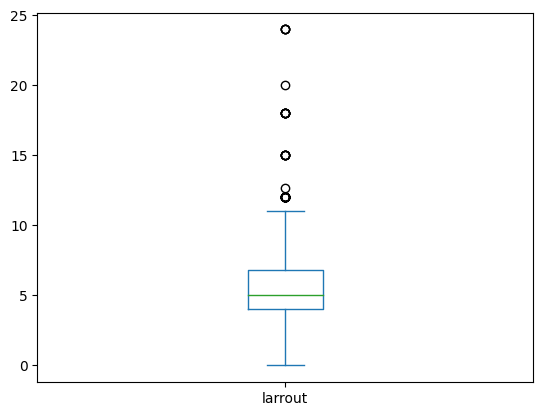

In [92]:
df_final["larrout"] = df_final.larrout.apply(lambda x: str(x).replace(",",".")).astype("float")
df_final["larrout"] = df_final["larrout"].replace({-1:np.NaN})
df_final[df_final["an"]>=2020].larrout.plot(kind="box")

In [96]:
df_final[df_final["an"]>=2020].larrout.describe()

count    602.000000
mean       5.615615
std        3.360120
min        0.000000
25%        4.000000
50%        5.000000
75%        6.850000
max       24.000000
Name: larrout, dtype: float64

<AxesSubplot: >

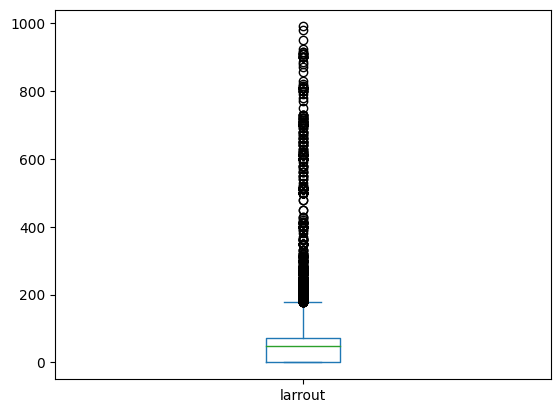

In [81]:
df_selected.larrout.plot(kind="box")